In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path
from collections.abc import Iterable

In [3]:
datapath = Path.cwd() / "data"
figurepath = Path.cwd().parent / "figures"

In [4]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [5]:
def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [6]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [7]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr

In [8]:
jobids = []
params = []
data = []
folder = datapath/"sectors"
files = ["1286{}_N15_ED.jld2".format(i) for i in range(79,89)]+["129519_N15_ED.jld2"]+["1286{}_N15_ED.jld2".format(i) for i in range(90,95)]+["138729_N15_ED.jld2"]
for (i,file) in enumerate(files):
    with h5py.File(folder/file,"r") as f:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])
#for  i in range(1,len(files)):
 #       data[i] = np.concatenate(data[i],axis=2)
#T = np.arange(0,2.01,0.01)

k down spins

In [9]:
N = 15
T = 10 ** np.linspace(-3,6,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])
dims = {0:1,
        1:15,
        2:105,
        3:455,
        4:1365,
        5:3003,
        6:5005,
        7:6435,
        8:6435,
        9:5005,
        10:3003,
        11:1365,
        12:455,
        13:105,
        14:15,
        15:1}

In [10]:
mags = np.zeros(N+1)
for k in range(N+1):
    mags[k] = k * (-1) + (N-k) * 1

In [11]:
res = [data[i][:,:,0] for i in range(N+1)]
res_total = data[-1][:,:,0]
red = list(map(symmetrize,res))
red_total = symmetrize(res_total)

In [12]:
means = np.zeros(N+1)
errs = np.zeros(N+1)
for k in range(N+1):
    means[k] = np.mean(red[k][66:])
    errs[k] = (np.std(red[k][66:],ddof=1))

#mean over above values
mean = 0
for k in range(N):
    mean += np.mean(red[k][66:])*dims[k]
mean = mean/2**N
err = 0
for k in range(N):
    err += (np.std(red[k][66:],ddof=1)*dims[k]/np.sqrt(34*8))**2
err = np.sqrt(err)/2**N
err

0.0001520524312424624

In [21]:
((N-2*n)/N)**2

5.4444444444444455

In [31]:
theo = np.zeros(16)
for k in range(16):
    n = N-k
    theo[k] = (2*(1-((N-2*n)/N)**2 * (2-((N-2*n)/N)**2)))

In [13]:
norms = {0: 0.0,
1: 0.2666666666666667,
2: 0.49523809523809514,
3: 0.6857142857142857,
4: 0.8380952380952381,
5: 0.9523809523809523,
6: 1.0285714285714285,
7: 1.0666666666666667,
8: 1.0666666666666667,
9: 1.0285714285714285,
10: 0.9523809523809523,
11: 0.8380952380952381,
12: 0.6857142857142857,
13: 0.49523809523809514,
14: 0.2666666666666667,
15: 0.0
}

In [14]:
mags2 = np.zeros(19+1)
for k in range(19+1):
    mags2[k] = k * (-1) + (19-k) * 1
norms2= {0: 0.0,
1: 0.21052631578947373,
2: 0.39766081871345027,
3: 0.5614035087719298,
4: 0.7017543859649122,
5: 0.8187134502923975,
6: 0.9122807017543859,
7: 0.9824561403508774,
8: 1.0292397660818715,
9: 1.0526315789473684,
10: 1.0526315789473684,
11: 1.0292397660818715,
12: 0.9824561403508774,
13: 0.9122807017543859,
14: 0.8187134502923975,
15: 0.7017543859649122,
16: 0.5614035087719298,
17: 0.39766081871345027,
18: 0.21052631578947373,
19: 0.0}

In [15]:
mags3 = np.zeros(25+1)
for k in range(25+1):
    mags3[k] = k * (-1) + (25-k) * 1
norms3= {0: 0.0,
1: 0.16000000000000003,
2: 0.30666666666666664,
3: 0.44,
4: 0.56,
5: 0.6666666666666666,
6: 0.76,
7: 0.84,
8: 0.9066666666666666,
9: 0.96,
10: 1.0,
11: 1.0266666666666668,
12: 1.04,
13: 1.04,
14: 1.0266666666666668,
15: 1.0,
16: 0.96,
17: 0.9066666666666666,
18: 0.84,
19: 0.76,
20: 0.6666666666666666,
21: 0.56,
22: 0.44,
23: 0.30666666666666664,
24: 0.16000000000000003,
25: 0.0}


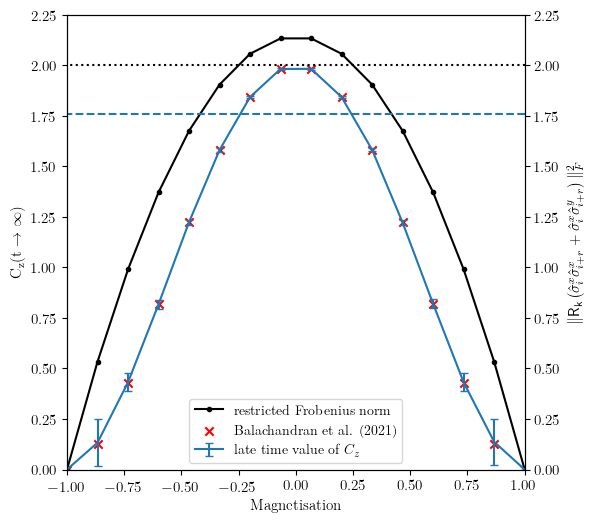

In [40]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)
axr = ax.twinx()
ax.plot(mags/15,list(map(lambda x: 2*x,norms.values())),c="black",label="restricted Frobenius norm",marker=".")
ax.errorbar(mags/15,means,yerr=errs,capsize=3,c="C0",label = r"late time value of $C_z$")
ax.plot(mags/15,mean*np.ones(N+1),c="C0",ls="dashed")
ax.scatter(mags/15,theo,c="red",marker="x",label="Balachandran et al. (2021)")
axr.plot(mags/15,2*np.ones(N+1),c="black",ls="dotted")
ax.set_xlabel("Magnetisation")
ax.set_ylabel(r"$\mathrm{C_z(t\rightarrow\infty)}$")
ax.set_xlim(-1,1)
ax.set_ylim(0,2.25)
ax.legend(loc = "best")
axr.set_ylim(0,2.25)
axr.set_ylabel(r"$\|\mathsf{R_k}\left(\hat{\sigma}_i^x\hat{\sigma}_{i+r}^x+\hat{\sigma}_i^x\hat{\sigma}_{i+r}^y\right)\|_F^2$")

plt.savefig(figurepath/"sectors_zz.pdf",format="pdf",bbox_inches='tight',dpi=600)
plt.show()

In [33]:
theo

array([0.        , 0.12389136, 0.42729877, 0.8192    , 1.22374321,
       1.58024691, 1.8432    , 1.98226173, 1.98226173, 1.8432    ,
       1.58024691, 1.22374321, 0.8192    , 0.42729877, 0.12389136,
       0.        ])

In [32]:
err

0.0001520524312424624